Importing necessary libraries for data manipulation, machine learning, and visualization, including pandas, numpy, sklearn modules, imblearn for handling imbalanced data, and shap for model interpretability.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

The dataset is loaded from a CSV file named 'Heart Disease indicator (version 1).csv' into a pandas DataFrame.

In [2]:
# Load the dataset
df = pd.read_csv('Heart Disease indicator (version 1).csv')

# Data Exploration
Basic exploration is performed to understand the dataset's structure, including printing the shape, the first few rows, column information (data types and non-null counts), and checking for missing values.   The distribution of the target variable 'HeartDisease' is checked, revealing a significant class imbalance.

# Data Preprocessing

In [3]:
# Explore the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:\n", df.head())
print("\nDataset Info:\n")
df.info()
print("\nMissing Values:\n", df.isnull().sum())
print("\nTarget Distribution:\n", df['HeartDisease'].value_counts())

Dataset Shape: (246022, 39)

First 5 Rows:
       Sex GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
0  Female     Very good                   4                 0   
1    Male     Very good                   0                 0   
2    Male     Very good                   0                 0   
3  Female          Fair                   5                 0   
4  Female          Good                   3                15   

                                     LastCheckupTime PhysicalActivities  \
0  Within past year (anytime less than 12 months ...                Yes   
1  Within past year (anytime less than 12 months ...                Yes   
2  Within past year (anytime less than 12 months ...                 No   
3  Within past year (anytime less than 12 months ...                Yes   
4  Within past year (anytime less than 12 months ...                Yes   

   SleepHours            RemovedTeeth HadAngina HadStroke  ...  \
0           9            None of them        No 

In [4]:
# Handle missing values
# For numerical columns, impute with median; for categorical, impute with mode
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [5]:
# Verify BMI calculation (HeightInM and WeightInK should match BMI)
# Recalculate BMI where necessary: BMI = weight (kg) / (height (m))^2
df['Calculated_BMI'] = df['WeightInKilograms'] / (df['HeightInMeters'] ** 2)
df['BMI'] = np.where(abs(df['BMI'] - df['Calculated_BMI']) > 0.1, df['Calculated_BMI'], df['BMI'])
df.drop(columns=['Calculated_BMI'], inplace=True)

# Remove duplicate records
df.drop_duplicates(inplace=True)
print("Shape after removing duplicates:", df.shape)

# Check missing values again
print("Missing Values after Imputation:\n", df.isnull().sum())

Shape after removing duplicates: (245986, 39)
Missing Values after Imputation:
 Sex                          0
GeneralHealth                0
PhysicalHealthDays           0
MentalHealthDays             0
LastCheckupTime              0
PhysicalActivities           0
SleepHours                   0
RemovedTeeth                 0
HadAngina                    0
HadStroke                    0
HadAsthma                    0
HadSkinCancer                0
HadCOPD                      0
HadDepressiveDisorder        0
HadKidneyDisease             0
HadArthritis                 0
HadDiabetes                  0
DeafOrHardOfHearing          0
BlindOrVisionDifficulty      0
DifficultyConcentrating      0
DifficultyWalking            0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
HeightInMeters               0
WeightInKilograms    

In [6]:
# Identify binary and multi-class categorical columns
binary_cols = [col for col in categorical_cols if df[col].nunique() == 2 and col != 'HeartDisease']
multi_class_cols = [col for col in categorical_cols if df[col].nunique() > 2]

# Label encoding for binary categorical features
label_encoders = {}
for col in binary_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Label encode the target variable (HeartDise)
le_target = LabelEncoder()
df['HeartDisease'] = le_target.fit_transform(df['HeartDisease'])

# One-hot encoding for multi-class categorical features
df = pd.get_dummies(df, columns=multi_class_cols, drop_first=True)

print("Shape after encoding:", df.shape)
print("First 5 Rows after encoding:\n", df.head())

Shape after encoding: (245986, 69)
First 5 Rows after encoding:
    Sex  PhysicalHealthDays  MentalHealthDays  PhysicalActivities  SleepHours  \
0    0                   4                 0                   1           9   
1    1                   0                 0                   1           6   
2    1                   0                 0                   0           8   
3    0                   5                 0                   1           9   
4    0                   3                15                   1           5   

   HadAngina  HadStroke  HadAsthma  HadSkinCancer  HadCOPD  ...  \
0          0          0          0              0        0  ...   
1          0          0          0              0        0  ...   
2          0          0          0              0        0  ...   
3          0          0          0              1        0  ...   
4          0          0          0              0        0  ...   

   AgeCategory_Age 60 to 64  AgeCategory_Age 65 to 

Handling Missing Values: The code includes a step to handle missing values, although the output of df.isnull().sum() shows no missing values in the dataset. If there were missing values, numerical columns would be imputed with the median and categorical columns with the mode.   BMI Verification: The code verifies the BMI calculation using 'WeightInKilograms' and 'HeightInMeters' and recalculates BMI where discrepancies exist, ensuring data consistency.   Removing Duplicates: Duplicate rows are removed from the dataset to avoid bias and improve model performance.   Encoding Categorical Features: Binary categorical columns (excluding the target) are identified and encoded using LabelEncoder.   The target variable 'HeartDisease' is also label encoded.   Multi-class categorical columns are one-hot encoded using pd.get_dummies to convert them into a numerical format suitable for machine learning models.

# Handling Class Imbalance with SMOTE
The dataset is split into features (X) and target (y).   SMOTE (Synthetic Minority Over-sampling Technique) is applied to the training data to oversample the minority class ('HeartDisease' = Yes) and balance the class distribution. This is crucial for training models on imbalanced datasets to prevent them from being biased towards the majority class.

In [7]:
# Separate features and target
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print("Shape of X after SMOTE:", X_balanced.shape)
print("Target Distribution after SMOTE:\n", pd.Series(y_balanced).value_counts())

Shape of X after SMOTE: (465102, 68)
Target Distribution after SMOTE:
 HeartDisease
0    232551
1    232551
Name: count, dtype: int64


# Feature Selection
The SelectKBest method with mutual_info_classif is used to select the top 20 features that have the highest mutual information score with the target variable. This helps in reducing dimensionality and potentially improving model performance and interpretability.   The selected feature names are printed.

In [8]:
# Feature selection using mutual information
selector = SelectKBest(score_func=mutual_info_classif, k=20)  # Select top 20 features
X_selected = selector.fit_transform(X_balanced, y_balanced)

# Get selected feature names
selected_features = X_balanced.columns[selector.get_support()].tolist()
X_selected = pd.DataFrame(X_selected, columns=selected_features)

print("Selected Features:", selected_features)
print("Shape after feature selection:", X_selected.shape)

Selected Features: ['Sex', 'PhysicalActivities', 'HadAngina', 'ChestScan', 'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers', 'GeneralHealth_Fair', 'GeneralHealth_Poor', 'LastCheckupTime_Within past year (anytime less than 12 months ago)', 'RemovedTeeth_6 or more, but not all', 'RemovedTeeth_All', 'RemovedTeeth_None of them', 'HadDiabetes_Yes', 'SmokerStatus_Former smoker', 'SmokerStatus_Never smoked', 'RaceEthnicityCategory_White only, Non-Hispanic', 'AgeCategory_Age 80 or older', 'TetanusLast10Tdap_Yes, received tetanus shot but not sure what type']
Shape after feature selection: (465102, 20)


# Data Splitting
The balanced dataset is split into training, validation, and test sets using train_test_split. A stratified split is used to maintain the target distribution in each subset

In [9]:
# Split the data
X_temp, X_test, y_temp, y_test = train_test_split(X_selected, y_balanced, test_size=0.15, random_state=42, stratify=y_balanced)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)  # 0.1765 of 85% is ~15%

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (325559, 20)
Validation set shape: (69777, 20)
Test set shape: (69766, 20)


In [10]:
y_test.to_csv('y_test.csv', index=False)

In [11]:
X_test.to_csv('X_test.csv', index=False)

# Model Training and Hyperparameter Tuning
Five different classification models are chosen: Logistic Regression, Random Forest, XGBoost, KNN, and MLP.   Parameter grids are defined for each model for hyperparameter tuning.   RandomizedSearchCV is used to find the best hyperparameters for each model based on the F1-score on the training data. The best estimator for each model is stored.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define models and parameter grids (SVM replaced with KNN)
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'KNN': KNeighborsClassifier(),  # Replaced SVM with KNN
    'MLP': MLPClassifier(max_iter=500)
}

param_grids = {
    'Logistic Regression': {'C': uniform(0.1, 10), 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
    'Random Forest': {'n_estimators': randint(50, 200), 'max_depth': randint(5, 20), 'min_samples_split': randint(2, 10)},
    'XGBoost': {'n_estimators': randint(50, 200), 'max_depth': randint(3, 10), 'learning_rate': uniform(0.01, 0.3)},
    'KNN': {'n_neighbors': randint(3, 15), 'weights': ['uniform', 'distance'], 'p': [1, 2]},  # p=1: Manhattan, p=2: Euclidean
    'MLP': {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': uniform(0.0001, 0.01), 'learning_rate': ['constant', 'adaptive']}
}

# Train and tune models
best_models = {}
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    search = RandomizedSearchCV(model, param_grids[model_name], n_iter=10, cv=3, scoring='f1', random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)
    best_models[model_name] = search.best_estimator_
    print(f"Best parameters for {model_name}:", search.best_params_)

Tuning Logistic Regression...
Best parameters for Logistic Regression: {'C': 0.6808361216819946, 'penalty': 'l2', 'solver': 'liblinear'}
Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': 19, 'min_samples_split': 4, 'n_estimators': 121}
Tuning XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.14777466758976016, 'max_depth': 7, 'n_estimators': 149}
Tuning KNN...
Best parameters for KNN: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Tuning MLP...
Best parameters for MLP: {'alpha': 0.0006641157902710027, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive'}


# Model Evaluation
A function demographic_parity is defined to calculate a fairness metric (Demographic Parity) based on a sensitive feature.   The trained models are evaluated on the validation set using various metrics: Accuracy, Precision, Recall, F1-Score, AUC-ROC, and Log Loss.   Demographic Parity is calculated for each model using 'Sex' as the sensitive feature.   The evaluation results are stored in a pandas DataFrame.   A 'Demographic Parity Diff' column is calculated to show the difference in prediction rates between the groups in the sensitive feature.   The model performance metrics table is printed.

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Function to calculate Demographic Parity (fairness metric)
def demographic_parity(y_pred, sensitive_feature):
    groups = sensitive_feature.unique()
    dp = {}
    for group in groups:
        mask = sensitive_feature == group
        dp[group] = np.mean(y_pred[mask])
    return dp

# Evaluate models
results = []
for model_name, model in best_models.items():
    # Predictions on validation set
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1-Score': f1_score(y_val, y_pred),
        'AUC-ROC': roc_auc_score(y_val, y_prob),
        'Log Loss': log_loss(y_val, y_prob)
    }
    
    # Fairness metric (using 'Sex' as the sensitive feature for now)
    sensitive_feature = X_val['Sex'] if 'Sex' in X_val.columns else X_val.iloc[:, 0]
    dp = demographic_parity(y_pred, sensitive_feature)
    metrics['Demographic Parity'] = dp
    
    results.append(metrics)

# Create a DataFrame for the results
results_df = pd.DataFrame(results)

# Simplify Demographic Parity for display (difference between groups)
results_df['Demographic Parity Diff'] = results_df['Demographic Parity'].apply(lambda x: max(x.values()) - min(x.values()))
results_df = results_df.drop(columns=['Demographic Parity'])

# Display the metrics table
print("\nModel Performance Metrics Table:\n")
print(results_df)


Model Performance Metrics Table:

                 Model  Accuracy  Precision    Recall  F1-Score   AUC-ROC  \
0  Logistic Regression  0.848159   0.860741  0.830715  0.845462  0.924050   
1        Random Forest  0.906101   0.908323  0.903377  0.905843  0.969526   
2              XGBoost  0.919931   0.938441  0.898819  0.918203  0.975587   
3                  KNN  0.922697   0.898675  0.952820  0.924956  0.970535   
4                  MLP  0.857904   0.881069  0.827505  0.853448  0.937873   

   Log Loss  Demographic Parity Diff  
0  0.351220                 0.099201  
1  0.236505                 0.083933  
2  0.193398                 0.087477  
3  0.662788                 0.083782  
4  0.314721                 0.091334  


# Best Model Selection and Saving
The best model is selected based on the highest AUC-ROC score on the validation set.   The metrics table is saved to a CSV file.  The best model is saved using joblib


Best Model Selected: XGBoost (based on AUC-ROC)


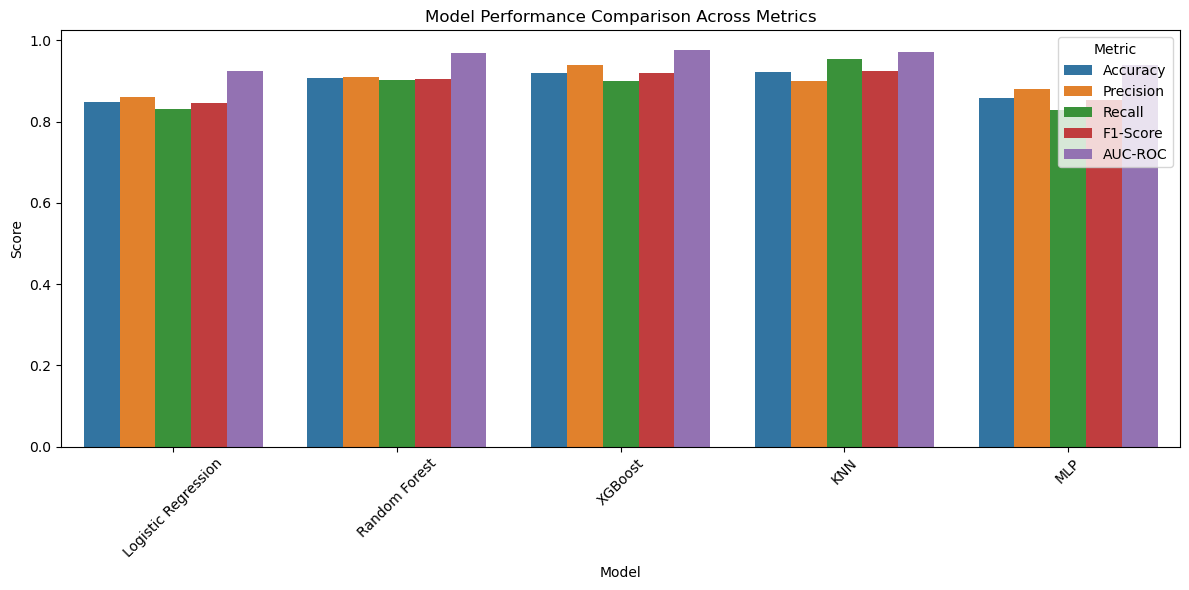

In [14]:
# Select the best model based on F1-Score
best_model_name = results_df.loc[results_df['AUC-ROC'].idxmax(), 'Model']
best_model = best_models[best_model_name]
print(f"\nBest Model Selected: {best_model_name} (based on AUC-ROC)")

# Save the metrics table
results_df.to_csv('final_model_metrics.csv', index=False)

# Visualize the metrics using a bar chart (excluding Log Loss and Demographic Parity Diff for clarity)
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
results_melted = results_df.melt(id_vars='Model', value_vars=metrics_to_plot, var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted)
plt.title('Model Performance Comparison Across Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_metrics_comparison.png')
plt.show()

# Model Performance Comparison Across Metrics
(model_metrics_comparison.png): This bar chart visualizes the performance of the different models across various metrics (Accuracy, Precision, Recall, F1-Score, AUC-ROC) on the validation set. It allows for a direct comparison of how each model performs in terms of its ability to correctly classify instances, minimize false positives, maximize true positives, and balance precision and recall. Higher scores generally indicate better performance for these metrics.

# Comfusion Matrix

In [17]:
from sklearn.metrics import confusion_matrix

# Function to extract confusion matrix values
def extract_confusion_matrix(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {'True Positive': tp, 'True Negative': tn, 'False Positive': fp, 'False Negative': fn}

# Create a list to store confusion matrix values
conf_matrix_results = []

for model_name, model in best_models.items():
    y_pred = model.predict(X_val)
    cm_values = extract_confusion_matrix(y_val, y_pred)
    cm_values['Model'] = model_name
    conf_matrix_results.append(cm_values)

# Convert to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix_results)

# Reorder columns for clarity
conf_matrix_df = conf_matrix_df[['Model', 'True Positive', 'True Negative', 'False Positive', 'False Negative']]

# Display the confusion matrix table
print("\nConfusion Matrix for All Models:\n")
print(conf_matrix_df)


Confusion Matrix for All Models:

                 Model  True Positive  True Negative  False Positive  \
0  Logistic Regression          28982          30200            4689   
1        Random Forest          31517          31708            3181   
2              XGBoost          31358          32832            2057   
3                  KNN          33242          31141            3748   
4                  MLP          28870          30992            3897   

   False Negative  
0            5906  
1            3371  
2            3530  
3            1646  
4            6018  


The confusion matrix reveals key insights into the strengths and weaknesses of each model in predicting heart disease. KNN stands out with the highest true positive count (33,242) and the lowest false negative (1,646), indicating it is highly effective at detecting patients with heart disease. However, this comes at the cost of a higher false positive count (3,748), which may lead to overdiagnosis. XGBoost shows a more conservative approach, achieving the lowest false positive rate (2,057) and a strong true negative count (32,832), making it suitable where false alarms are costly. Random Forest performs consistently, with high true positive (31,517) and true negative (31,708) values, offering a good balance between sensitivity and specificity. In contrast, Logistic Regression and MLP both show weaker sensitivity, reflected in higher false negative values (5,906 and 6,018 respectively), suggesting a greater risk of missing true cases of heart disease.

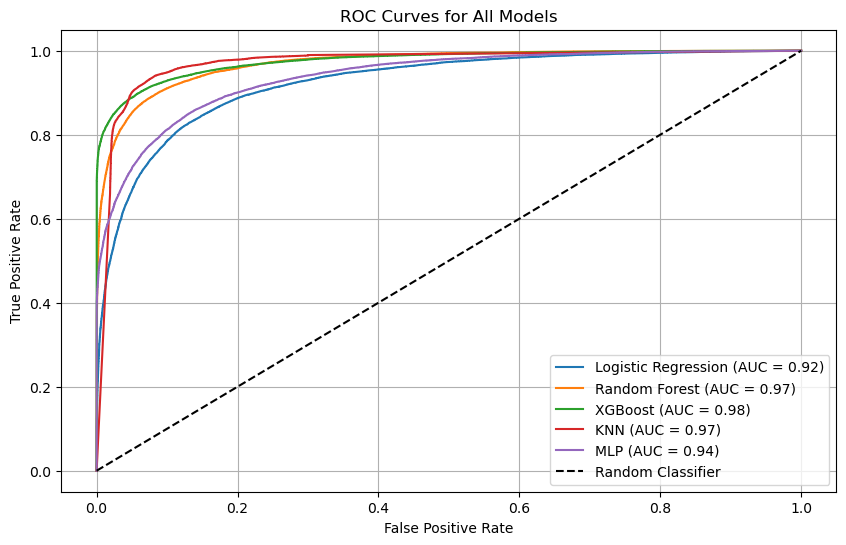

In [18]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 6))
for model_name, model in best_models.items():
    y_prob = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curves_all_models.png')
plt.show()

This plot shows the Receiver Operating Characteristic (ROC) curve for each trained model. The ROC curve illustrates the trade-off between the True Positive Rate (sensitivity) and the False Positive Rate (1-specificity) at various probability thresholds. The area under the ROC curve (AUC-ROC) is a single scalar value that summarizes the model's ability to discriminate between the positive and negative classes. A higher AUC-ROC indicates better discriminatory power, with a value of 1 representing a perfect classifier and 0.5 representing a random classifier. The diagonal line represents a random classifier.

# Model Interpretability (SHAP)
The SHAP library is used to explain the predictions of the best model.   A function get_shap_explainer is defined to choose the appropriate SHAP explainer based on the model type.   SHAP values are computed for the test set.   A SHAP summary plot is generated to show the global feature importance.   A SHAP force plot (or waterfall plot if force plot is not supported) is generated to explain a single prediction instance.   A text-based explanation for a single instance is also provided, highlighting the top contributing features.

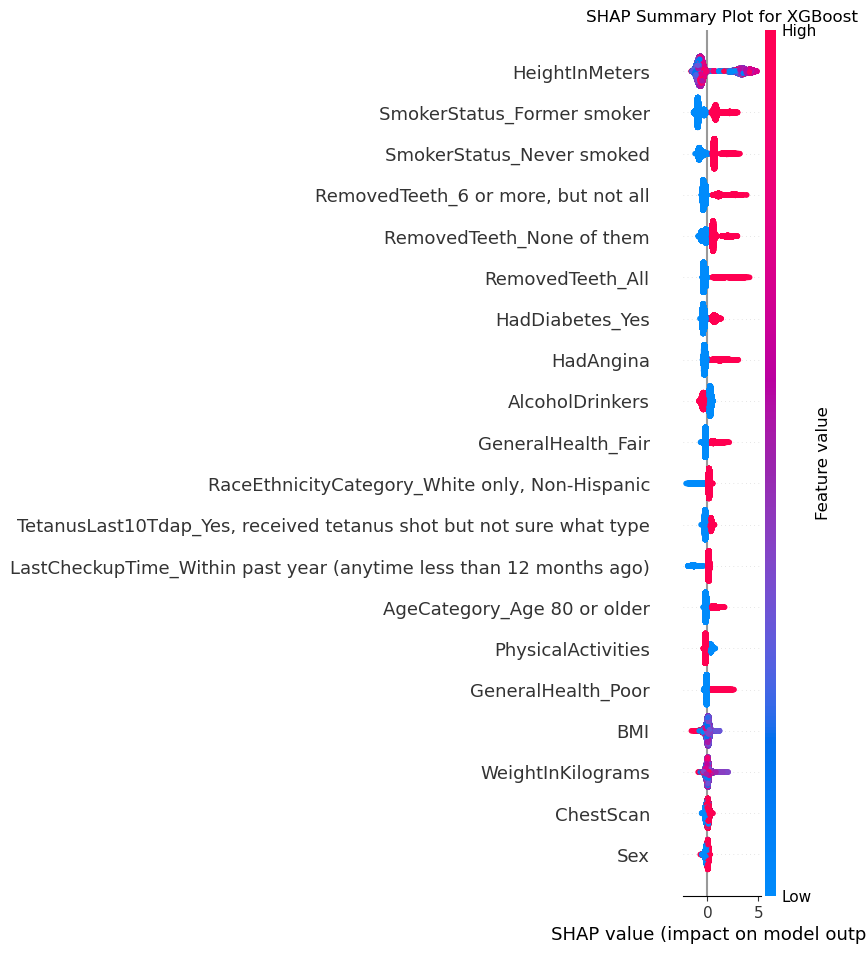

In [19]:
import shap

# Function to initialize the appropriate SHAP explainer based on the model type
def get_shap_explainer(model, model_name, X_train):
    if 'XGBoost' in model_name:
        # For tree-based models like XGBoost
        explainer = shap.TreeExplainer(model)
    elif 'Random Forest' in model_name:
        # For Random Forest
        explainer = shap.TreeExplainer(model)
    elif 'Logistic Regression' in model_name:
        # For Logistic Regression
        explainer = shap.LinearExplainer(model, X_train)
    elif 'KNN' in model_name:
        # For KNN, use KernelExplainer (model-agnostic, can be slow, so we sample the training data)
        background = X_train.sample(100, random_state=42)  # Use a smaller background dataset
        explainer = shap.KernelExplainer(model.predict_proba, background)
    elif 'MLP' in model_name:
        # For MLP (neural network), use KernelExplainer
        background = X_train.sample(100, random_state=42)  # Use a smaller background dataset
        explainer = shap.KernelExplainer(model.predict_proba, background)
    else:
        raise ValueError(f"SHAP explainer not defined for model: {model_name}")
    return explainer

# Get the appropriate SHAP explainer for the best model
explainer = get_shap_explainer(best_model, best_model_name, X_train)

# Compute SHAP values for the test set
# Handle different SHAP value outputs based on the explainer type
if 'KernelExplainer' in str(type(explainer)):
    # For KernelExplainer (KNN, MLP), we need to pass the data directly
    shap_values = explainer.shap_values(X_test, nsamples=100)  # Limit samples for speed
    # KernelExplainer returns a list of SHAP values for each class; we take the values for class 1
    shap_values = shap_values[1]  # Class 1 (positive class: heart disease)
else:
    # For TreeExplainer or LinearExplainer
    shap_values = explainer(X_test)
    # If the output is a shap.Explanation object, extract the values for class 1
    if isinstance(shap_values, shap.Explanation):
        shap_values = shap_values.values[:, :, 1] if shap_values.values.ndim == 3 else shap_values.values

# Global interpretability: Summary plot
plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.title(f'SHAP Summary Plot for {best_model_name}')
plt.savefig('shap_summary_best_model.png')
plt.show()

This plot provides a global view of feature importance for the best model (XGBoost, based on the output). Each dot represents an instance from the test set. The position of the dot on the x-axis indicates the SHAP value for that feature and instance, showing how much that feature's value contributed to the prediction. The color of the dot represents the feature value (e.g., red for high, blue for low). Features are ordered by their overall importance, with the most important features at the top. This plot helps in understanding which features have the most impact on the model's predictions and in which direction (positive or negative SHAP values)

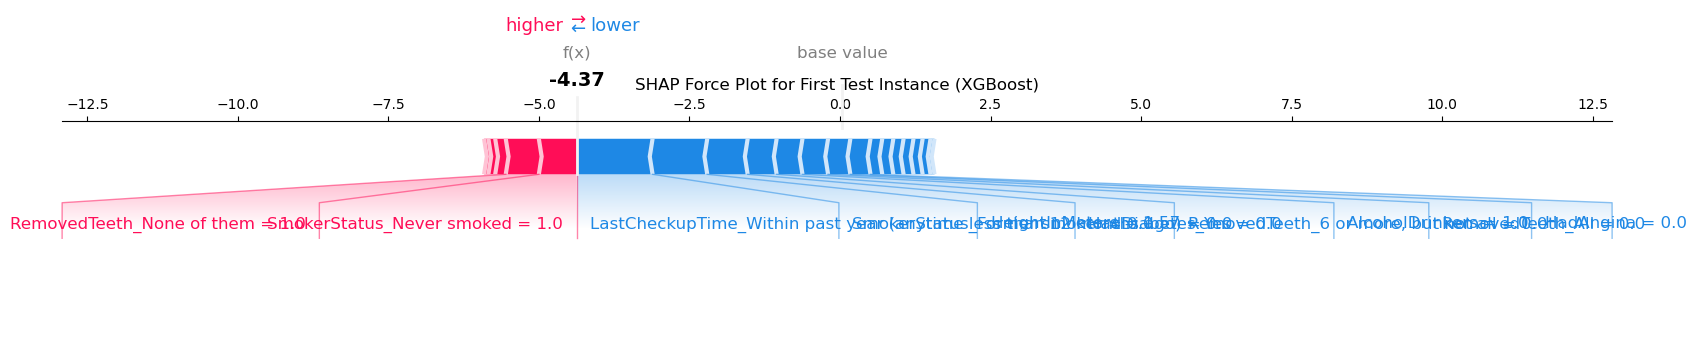

In [20]:
# Local interpretability: Force plot for a single prediction (first test instance)
# Force plots are not directly supported for KernelExplainer in matplotlib mode, so we use a fallback
try:
    shap.initjs()
    shap.force_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value, 
                    shap_values[0], X_test.iloc[0], show=False, matplotlib=True)
    plt.title(f'SHAP Force Plot for First Test Instance ({best_model_name})')
    plt.savefig('shap_force_plot_best_model.png')
    plt.show()
except:
    print("Force plot not supported for this model in matplotlib mode. Using waterfall plot instead.")
    shap.waterfall_plot(shap.Explanation(values=shap_values[0], 
                                         base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value, 
                                         data=X_test.iloc[0], 
                                         feature_names=X_test.columns), show=False)
    plt.title(f'SHAP Waterfall Plot for First Test Instance ({best_model_name})')
    plt.savefig('shap_waterfall_plot_best_model.png')
    plt.show()

These plots provide local interpretability, explaining the prediction for a single instance. The force plot (or waterfall plot) shows how each feature's value pushes the prediction from the base value (average prediction) to the final output value for that specific instance. Red represents features that increase the prediction (towards predicting heart disease), and blue represents features that decrease the prediction (away from predicting heart disease). The magnitude of the effect is shown by the length of the bars.

In [21]:
# Text-based explanation for the first test instance
shap_values_instance = shap_values[0]
top_features = np.argsort(np.abs(shap_values_instance))[-3:]  # Top 3 features
text_explanation = f"Prediction for instance 0: {best_model.predict(X_test.iloc[[0]])[0]}\n"
for idx in top_features:
    feature_name = X_test.columns[idx]
    feature_value = X_test.iloc[0, idx]
    shap_value = shap_values_instance[idx]
    text_explanation += f"Feature '{feature_name}' (value: {feature_value:.2f}) contributed {shap_value:.2f} to the prediction.\n"
print("Text Explanation:\n", text_explanation)

# Save text explanation
with open('shap_text_explanation_best_model.txt', 'w') as f:
    f.write(text_explanation)

Text Explanation:
 Prediction for instance 0: 0
Feature 'HeightInMeters' (value: 1.57) contributed -0.67 to the prediction.
Feature 'SmokerStatus_Former smoker' (value: 0.00) contributed -0.91 to the prediction.
Feature 'LastCheckupTime_Within past year (anytime less than 12 months ago)' (value: 0.00) contributed -1.26 to the prediction.



In [22]:
import joblib

# Save the best model
joblib.dump(best_model, f'best_model_{best_model_name.lower().replace(" ", "_")}.joblib')
print(f"Best model saved as 'best_model_{best_model_name.lower().replace(' ', '_')}.joblib'")

# Save all artifacts
results_df.to_csv('final_model_metrics.csv', index=False)
print("Metrics table saved as 'final_model_metrics.csv'")
print("SHAP visualizations saved as 'shap_summary_best_model.png' and 'shap_force_plot_best_model.png' (or 'shap_waterfall_plot_best_model.png')")
print("Text explanation saved as 'shap_text_explanation_best_model.txt'")
print("ROC curves saved as 'roc_curves_all_models.png'")
print("Model metrics comparison chart saved as 'model_metrics_comparison.png'")

Best model saved as 'best_model_xgboost.joblib'
Metrics table saved as 'final_model_metrics.csv'
SHAP visualizations saved as 'shap_summary_best_model.png' and 'shap_force_plot_best_model.png' (or 'shap_waterfall_plot_best_model.png')
Text explanation saved as 'shap_text_explanation_best_model.txt'
ROC curves saved as 'roc_curves_all_models.png'
Model metrics comparison chart saved as 'model_metrics_comparison.png'


In [23]:
X.columns

Index(['Sex', 'PhysicalHealthDays', 'MentalHealthDays', 'PhysicalActivities',
       'SleepHours', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer',
       'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'ChestScan',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'HighRiskLastYear',
       'GeneralHealth_Fair', 'GeneralHealth_Good', 'GeneralHealth_Poor',
       'GeneralHealth_Very good',
       'LastCheckupTime_Within past 2 years (1 year but less than 2 years ago)',
       'LastCheckupTime_Within past 5 years (2 years but less than 5 years ago)',
       'LastCheckupTime_Within past year (anytime less than 12 months ago)',
       'RemovedTeeth_6 or more, but not all', 'RemovedTeeth_All',
       'RemovedTeeth_None

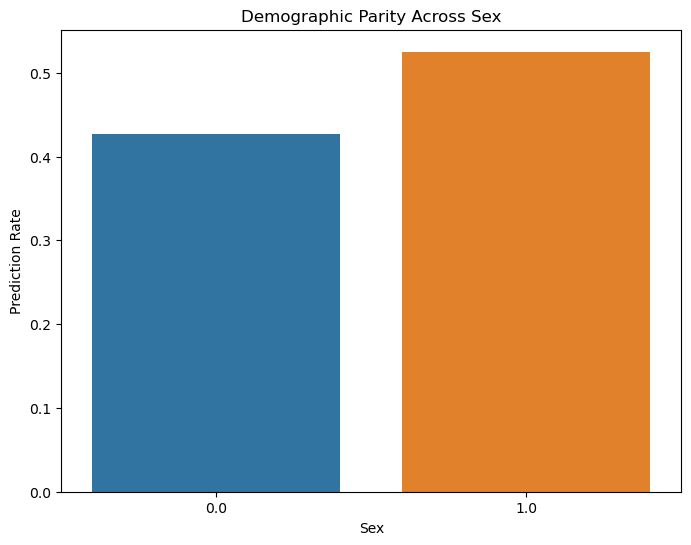

Fairness analysis plot saved successfully at: 'fairness_analysis.png'


In [25]:
import os
# Generate and save the fairness analysis plot using the best model on the test set
y_pred_test = best_model.predict(X_test)
sensitive_feature_name = 'Sex'  # Default sensitive feature; can be changed to AgeCateg or RaceEthni
sensitive_feature = X_test[sensitive_feature_name]
dp = demographic_parity(y_pred_test, sensitive_feature)

plt.figure(figsize=(8, 6))
sns.barplot(x=list(dp.keys()), y=list(dp.values()))
plt.title(f'Demographic Parity Across {sensitive_feature_name}')
plt.xlabel(sensitive_feature_name)
plt.ylabel('Prediction Rate')
plt.savefig('fairness_analysis.png')
plt.show()

# Confirm the fairness plot was saved
print(f"Fairness analysis plot saved successfully at: 'fairness_analysis.png'")

Gender Distribution in Test Set:
Sex
1.0    35925
0.0    33841
Name: count, dtype: int64
Men indices: [    2     4     7 ... 69760 69761 69765] No of Men = 35925
Women indices: [    0     1     3 ... 69762 69763 69764] No of Women = 33841

Male Confusion Matrix Metrics:
TN=15104, FP=1252, FN=1956, TP=17613


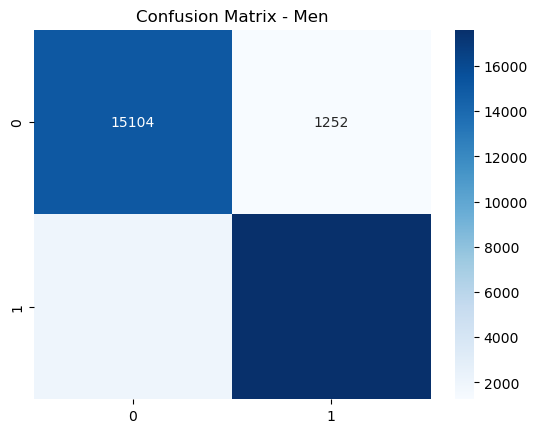

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import joblib

# Load the test set and the best model
X_test = pd.read_csv('X_test.csv')  # Full test set with one-hot encoded features
y_test = pd.read_csv('y_test.csv')  # Test labels
best_model = joblib.load('best_model_xgboost.joblib')  # Load the best model

# Ensure the selected features match the model's expected features
model_features = best_model.get_booster().feature_names
if model_features is None:
    raise ValueError("Feature names are not available in the model. Ensure the model was trained with a DataFrame or DMatrix with feature names.")

# Update selected_features.txt with the model's expected features
with open('selected_features.txt', 'w') as f:
    f.write('\n'.join(model_features))

# Reload the selected features
with open('selected_features.txt', 'r') as f:
    selected_features = f.read().splitlines()

# Add missing features to X_test with default value 0
missing_features = [f for f in selected_features if f not in X_test.columns]
for feature in missing_features:
    X_test[feature] = 0

# Create X_test_selected with the correct features
X_test_selected = X_test[selected_features]

# Ensure y_test is a Series
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0]

# 1. Fairness Analysis: Sex
PROTECTED_SEX = "Sex"
MEN = 1
WOMEN = 0

# Gender distribution in the test set
gender_dist = X_test[PROTECTED_SEX].value_counts()
print("Gender Distribution in Test Set:")
print(gender_dist)

# Indices for men and women
men_indices = np.where(X_test[PROTECTED_SEX] == MEN)[0]
women_indices = np.where(X_test[PROTECTED_SEX] == WOMEN)[0]
print("Men indices:", men_indices, "No of Men =", men_indices.size)
print("Women indices:", women_indices, "No of Women =", women_indices.size)

# Predictions for men and women
y_pred = best_model.predict(X_test_selected)
y_prob = best_model.predict_proba(X_test_selected)[:, 1] if hasattr(best_model, 'predict_proba') else best_model.decision_function(X_test_selected)

# Subset predictions and probabilities for men and women
y_test_men = y_test.iloc[men_indices]
y_test_women = y_test.iloc[women_indices]
y_pred_men = [y_pred[i] for i in men_indices]
y_pred_women = [y_pred[i] for i in women_indices]
y_prob_men = [y_prob[i] for i in men_indices]
y_prob_women = [y_prob[i] for i in women_indices]

# Metrics for men
cm_male = confusion_matrix(y_test_men, y_pred_men)
tn, fp, fn, tp = cm_male.ravel()
print("\nMale Confusion Matrix Metrics:")
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
disp = sns.heatmap(cm_male, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Men')
plt.savefig('cm_male.png')
plt.show()

Men: Accuracy=0.91, Recall=0.90, Precision=0.93, Positive Rate=0.53, F1=0.92, ROC-AUC=0.97

Female Confusion Matrix Metrics:
TN=17753, FP=774, FN=1629, TP=13685


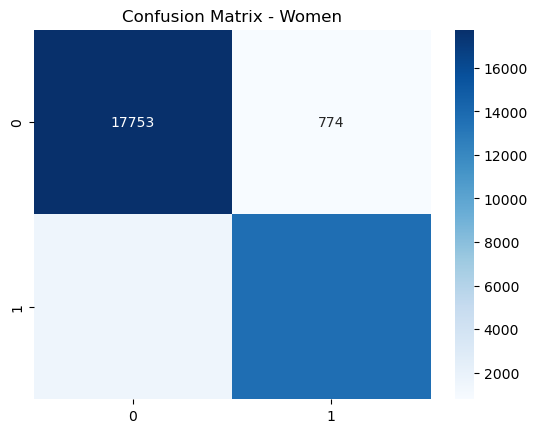

Women: Accuracy=0.93, Recall=0.89, Precision=0.95, Positive Rate=0.43, F1=0.92, ROC-AUC=0.98


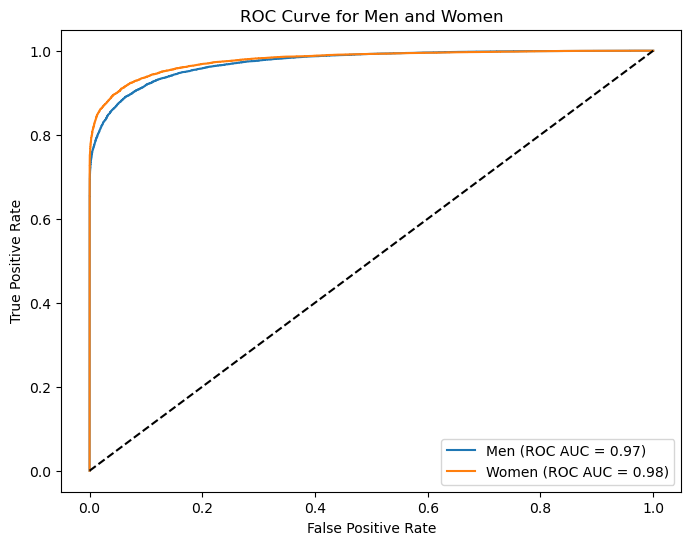


ROC AUC Score for Men: 0.9729719459612662
ROC AUC Score for Women: 0.9785516993828032


In [27]:
accuracy_men = accuracy_score(y_test_men, y_pred_men)
recall_men = recall_score(y_test_men, y_pred_men, zero_division=0)
precision_men = precision_score(y_test_men, y_pred_men, zero_division=0)
positive_rate_men = sum(y_pred_men) / len(y_pred_men)
f1_men = f1_score(y_test_men, y_pred_men, zero_division=0)
roc_auc_men = roc_auc_score(y_test_men, y_prob_men)
print(f"Men: Accuracy={accuracy_men:.2f}, Recall={recall_men:.2f}, Precision={precision_men:.2f}, Positive Rate={positive_rate_men:.2f}, F1={f1_men:.2f}, ROC-AUC={roc_auc_men:.2f}")

# Metrics for women
cm_female = confusion_matrix(y_test_women, y_pred_women)
tn, fp, fn, tp = cm_female.ravel()
print("\nFemale Confusion Matrix Metrics:")
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
disp = sns.heatmap(cm_female, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Women')
plt.savefig('cm_female.png')
plt.show()

accuracy_women = accuracy_score(y_test_women, y_pred_women)
recall_women = recall_score(y_test_women, y_pred_women, zero_division=0)
precision_women = precision_score(y_test_women, y_pred_women, zero_division=0)
positive_rate_women = sum(y_pred_women) / len(y_pred_women)
f1_women = f1_score(y_test_women, y_pred_women, zero_division=0)
roc_auc_women = roc_auc_score(y_test_women, y_prob_women)
print(f"Women: Accuracy={accuracy_women:.2f}, Recall={recall_women:.2f}, Precision={precision_women:.2f}, Positive Rate={positive_rate_women:.2f}, F1={f1_women:.2f}, ROC-AUC={roc_auc_women:.2f}")

# ROC curve for men and women
fpr_men, tpr_men, _ = roc_curve(y_test_men, y_prob_men)
fpr_women, tpr_women, _ = roc_curve(y_test_women, y_prob_women)
plt.figure(figsize=(8, 6))
plt.plot(fpr_men, tpr_men, label=f'Men (ROC AUC = {roc_auc_men:.2f})')
plt.plot(fpr_women, tpr_women, label=f'Women (ROC AUC = {roc_auc_women:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Men and Women')
plt.legend()
plt.savefig('roc_sex.png')
plt.show()
print("\nROC AUC Score for Men:", roc_auc_men)
print("ROC AUC Score for Women:", roc_auc_women)

One-hot encoded AgeCategory columns: ['AgeCategory_Age 80 or older']

Age Group Distribution in Test Set:
age_group
old    69766
Name: count, dtype: int64

Fairness Metrics by Age Group:
Age group young: No data available in the test set.
Age group adult: No data available in the test set.
Age group old: Accuracy=0.92, Precision=0.94, Recall=0.90, F1=0.92, ROC-AUC=0.98, Positive Rate=0.48

Old Age Group Confusion Matrix Metrics:
TN=32857, FP=2026, FN=3585, TP=31298


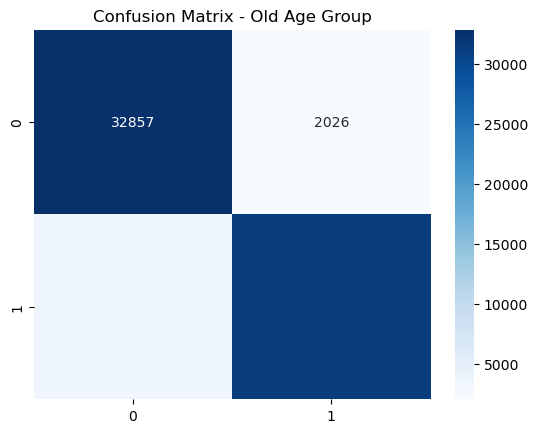

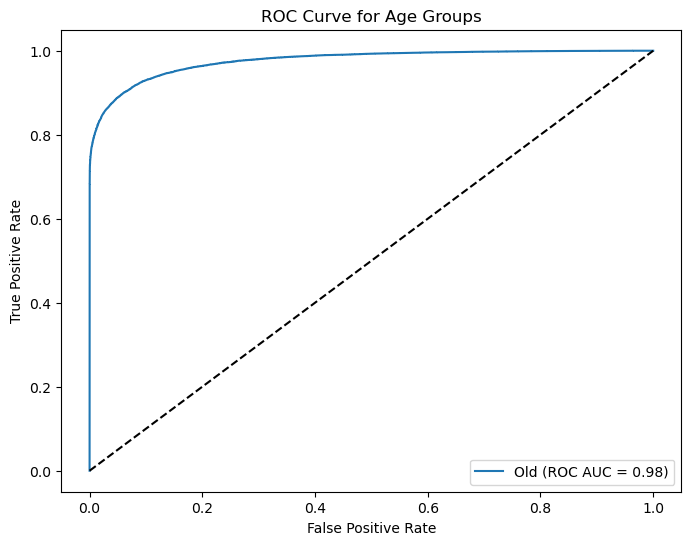

In [28]:
# 2. Fairness Analysis: Age
# Identify one-hot encoded AgeCategory columns
age_columns = [col for col in X_test.columns if col.startswith('AgeCategory_')]
print("One-hot encoded AgeCategory columns:", age_columns)

# Function to infer the original AgeCategory from one-hot encoded columns
def infer_age_category(row):
    for col in age_columns:
        if row[col] == 1:
            # Extract the age category (e.g., 'Age 80 or older' from 'AgeCategory_Age 80 or older')
            return col.replace('AgeCategory_', '')
    return None  # In case no age category is found (shouldn't happen if data is clean)

# Function to categorize age based on the inferred AgeCategory
def categorize_age(age_category):
    if age_category in ['Age 18 to 24', 'Age 25 to 34', 'Age 35 to 44']:
        return 'young'
    elif age_category in ['Age 45 to 54', 'Age 55 to 64']:
        return 'adult'
    else:  # 'Age 65 to 79', 'Age 80 or older'
        return 'old'

# Add age group column to X_test by inferring AgeCategory
X_test_with_age_group = X_test.copy()
X_test_with_age_group['inferred_age_category'] = X_test_with_age_group.apply(infer_age_category, axis=1)
X_test_with_age_group['age_group'] = X_test_with_age_group['inferred_age_category'].apply(categorize_age)

# Age group distribution
age_dist = X_test_with_age_group['age_group'].value_counts()
print("\nAge Group Distribution in Test Set:")
print(age_dist)

# Fairness metrics by age group
age_groups = ['young', 'adult', 'old']
roc_curves_age = {}
print("\nFairness Metrics by Age Group:")
for group in age_groups:
    indices = X_test_with_age_group[X_test_with_age_group['age_group'] == group].index
    if len(indices) == 0:
        print(f"Age group {group}: No data available in the test set.")
        continue  # Skip this group if there are no rows

    y_test_group = y_test.loc[indices]
    X_test_group = X_test_selected.loc[indices]

    y_pred_group = best_model.predict(X_test_group)
    y_prob_group = best_model.predict_proba(X_test_group)[:, 1] if hasattr(best_model, 'predict_proba') else best_model.decision_function(X_test_group)

    accuracy = accuracy_score(y_test_group, y_pred_group)
    precision = precision_score(y_test_group, y_pred_group, zero_division=0)
    recall = recall_score(y_test_group, y_pred_group, zero_division=0)
    f1 = f1_score(y_test_group, y_pred_group, zero_division=0)
    roc_auc = roc_auc_score(y_test_group, y_prob_group)
    positive_rate = sum(y_pred_group) / len(y_pred_group)
    print(f"Age group {group}: Accuracy={accuracy:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}, ROC-AUC={roc_auc:.2f}, Positive Rate={positive_rate:.2f}")

    cm = confusion_matrix(y_test_group, y_pred_group)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{group.capitalize()} Age Group Confusion Matrix Metrics:")
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    disp = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {group.capitalize()} Age Group')
    plt.savefig(f'cm_age_{group}.png')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test_group, y_prob_group)
    roc_curves_age[group] = (fpr, tpr, roc_auc)

# Plot ROC curves for age groups (only for groups with data)
if roc_curves_age:  # Check if there are any ROC curves to plot
    plt.figure(figsize=(8, 6))
    for group, (fpr, tpr, roc_auc) in roc_curves_age.items():
        plt.plot(fpr, tpr, label=f'{group.capitalize()} (ROC AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Age Groups')
    plt.legend()
    plt.savefig('roc_age.png')
    plt.show()
else:
    print("No ROC curves to plot for age groups (all groups are empty).")

One-hot encoded RaceEthnicityCategory columns: ['RaceEthnicityCategory_White only, Non-Hispanic']

Race/Ethnicity Distribution in Test Set:
inferred_race_category
White only, Non-Hispanic    59012
Name: count, dtype: int64

Fairness Metrics by Race/Ethnicity:
Race/Ethnicity White only, Non-Hispanic: Accuracy=0.92, Precision=0.94, Recall=0.91, F1=0.92, ROC-AUC=0.98, Positive Rate=0.54

White only, Non-Hispanic Confusion Matrix Metrics:
TN=24371, FP=1868, FN=3057, TP=29716


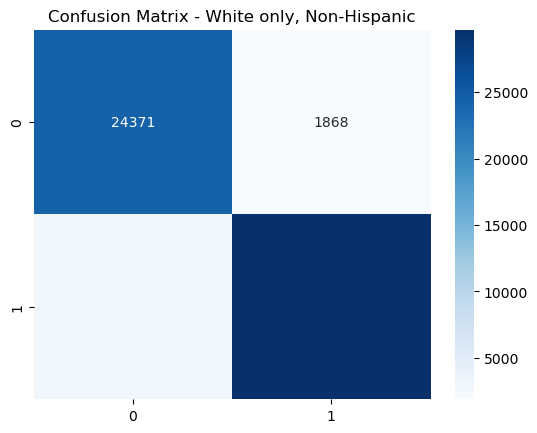

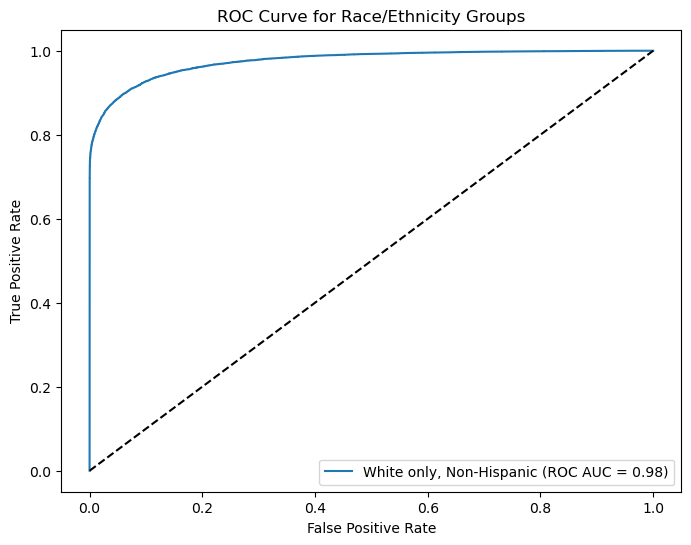

In [29]:
# 3. Fairness Analysis: Race/Ethnicity
# Identify one-hot encoded RaceEthnicityCategory columns
race_columns = [col for col in X_test.columns if col.startswith('RaceEthnicityCategory_')]
print("One-hot encoded RaceEthnicityCategory columns:", race_columns)

# Function to infer the original RaceEthnicityCategory from one-hot encoded columns
def infer_race_category(row):
    for col in race_columns:
        if row[col] == 1:
            # Extract the race category (e.g., 'White only, Non-Hispanic' from 'RaceEthnicityCategory_White only, Non-Hispanic')
            return col.replace('RaceEthnicityCategory_', '')
    return None  # In case no race category is found (shouldn't happen if data is clean)

# Add race category column to X_test by inferring RaceEthnicityCategory
X_test_with_race = X_test.copy()
X_test_with_race['inferred_race_category'] = X_test_with_race.apply(infer_race_category, axis=1)

# Race/ethnicity distribution
if race_columns:
    race_dist = X_test_with_race['inferred_race_category'].value_counts()
    print("\nRace/Ethnicity Distribution in Test Set:")
    print(race_dist)

    # Fairness metrics by race/ethnicity
    race_categories = X_test_with_race['inferred_race_category'].unique()
    roc_curves_race = {}
    print("\nFairness Metrics by Race/Ethnicity:")
    for race in race_categories:
        if pd.isna(race):  # Skip rows where race couldn't be inferred
            continue
        indices = X_test_with_race[X_test_with_race['inferred_race_category'] == race].index
        if len(indices) == 0:
            print(f"Race/Ethnicity {race}: No data available in the test set.")
            continue

        y_test_group = y_test.loc[indices]
        X_test_group = X_test_selected.loc[indices]

        y_pred_group = best_model.predict(X_test_group)
        y_prob_group = best_model.predict_proba(X_test_group)[:, 1] if hasattr(best_model, 'predict_proba') else best_model.decision_function(X_test_group)

        accuracy = accuracy_score(y_test_group, y_pred_group)
        precision = precision_score(y_test_group, y_pred_group, zero_division=0)
        recall = recall_score(y_test_group, y_pred_group, zero_division=0)
        f1 = f1_score(y_test_group, y_pred_group, zero_division=0)
        roc_auc = roc_auc_score(y_test_group, y_prob_group)
        positive_rate = sum(y_pred_group) / len(y_pred_group)
        print(f"Race/Ethnicity {race}: Accuracy={accuracy:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}, ROC-AUC={roc_auc:.2f}, Positive Rate={positive_rate:.2f}")

        cm = confusion_matrix(y_test_group, y_pred_group)
        tn, fp, fn, tp = cm.ravel()
        print(f"\n{race} Confusion Matrix Metrics:")
        print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
        disp = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {race}')
        plt.savefig(f'cm_race_{race.replace(" ", "_").replace(",", "")}.png')
        plt.show()

        fpr, tpr, _ = roc_curve(y_test_group, y_prob_group)
        roc_curves_race[race] = (fpr, tpr, roc_auc)

    # Plot ROC curves for race/ethnicity groups
    if roc_curves_race:
        plt.figure(figsize=(8, 6))
        for race, (fpr, tpr, roc_auc) in roc_curves_race.items():
            plt.plot(fpr, tpr, label=f'{race} (ROC AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='black')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Race/Ethnicity Groups')
        plt.legend()
        plt.savefig('roc_race.png')
        plt.show()
    else:
        print("No ROC curves to plot for race/ethnicity groups (all groups are empty).")
else:
    print("No RaceEthnicityCategory columns found in X_test. Skipping race/ethnicity fairness analysis.")

Demographic Parity Across Sex (fairness_analysis.png): This bar chart shows the average prediction rate (proportion of instances predicted as having heart disease) for each group within the 'Sex' sensitive feature (Male and Female). Demographic Parity is achieved when these prediction rates are roughly equal across all groups. Significant differences indicate potential bias in the model's predictions against certain groups.  

Confusion Matrix - Men (cm_male.png) and Confusion Matrix - Women (cm_female.png): These heatmaps display the confusion matrix for the best model separately for the male and female subsets of the test data. A confusion matrix shows the counts of True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN). By comparing the confusion matrices for different groups, you can assess if the model has significantly different error rates (e.g., higher false positive rates or false negative rates) for one group compared to another.  

ROC Curve for Men and Women (roc_sex.png): This plot compares the ROC curves for the best model when evaluated on the male and female subsets of the test data. Comparing the ROC curves and their corresponding AUC-ROC scores for different groups helps in assessing if the model's discriminatory ability varies across these groups. Similar curves and AUC-ROC scores suggest fairer performance in terms of discrimination.  

Confusion Matrix - [Age Group] Age Group (cm_age_[group].png): These heatmaps (though only the 'old' group was evaluated in the output) show the confusion matrix for the best model for specific age groups. This allows for an analysis of the model's performance and error distribution within different age brackets.  

ROC Curve for Age Groups (roc_age.png): This plot (though only for the 'old' group in the output) compares the ROC curves for the best model when evaluated on different age groups. Similar to the sex-based ROC curve comparison, this helps assess if the model's discriminatory power is consistent across different age groups.  

Confusion Matrix - [Race] (cm_race_[race].png): These heatmaps (though only for 'White only, Non-Hispanic' in the output) show the confusion matrix for the best model for specific racial/ethnic groups. This helps in understanding the model's performance and error patterns within different racial/ethnic categories.  

ROC Curve for Race/Ethnicity Groups (roc_race.png): This plot (though only for 'White only, Non-Hispanic' in the output) compares the ROC curves for the best model when evaluated on different racial/ethnic groups. This allows for an assessment of whether the model's ability to discriminate between classes is similar across different racial/ethnic backgrounds.  

Overall, the code provides a comprehensive approach to building and evaluating a heart disease prediction model, with a strong emphasis on assessing and visualizing fairness across different demographic groups. The graphs provide insightful visual summaries of model performance, feature importance, and fairness metrics.

In [30]:
conf_matrix_df

,Model,True Positive,True Negative,False Positive,False Negative
0,Logistic Regression,28982,30200,4689,5906
1,Random Forest,31517,31708,3181,3371
2,XGBoost,31358,32832,2057,3530
3,KNN,33242,31141,3748,1646
4,MLP,28870,30992,3897,6018
